# Lupus local

In [1]:
import aplpy
from astropy.io import fits
%matplotlib widget
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from pywavan import powspec, fan_trans, fbm2d, apodize, padding, locspec

In [3]:
import pandas as pd

In [4]:
cores = pd.read_excel("/user/workdir/albouyg/Gouldbelt/Lupus_loc/lupus_cores.xlsx")
nb = cores['Nb'].to_numpy()
ra = cores['RA'].to_numpy()
decl = cores['DEC'].to_numpy()
width = cores['A_FWHM'].to_numpy()
height = cores['B_FWHM'].to_numpy()
angle = cores['Theta'].to_numpy()
mass = cores['Mass'].to_numpy()

In [5]:
#Degrees convertion
ac=np.zeros(ra.size)
dec=np.zeros(decl.size)
for i in range(ra.size):
    ac[i]=(float(ra[i][0:2])*15+float(ra[i][3:5])*0.25+float(ra[i][6:])/240)
    dec[i]=-(float(decl[i][1:3])+float(decl[i][4:6])/60+float(decl[i][7:])/3600)

In [6]:
figfile = '/user/workdir/albouyg/Gouldbelt/Lupus_loc/HGBS_lupIII_column_density_map_rebin_rot_cut.fits'

INFO: Auto-setting vmin to  3.670e+20 [aplpy.core]
INFO: Auto-setting vmax to  9.327e+21 [aplpy.core]


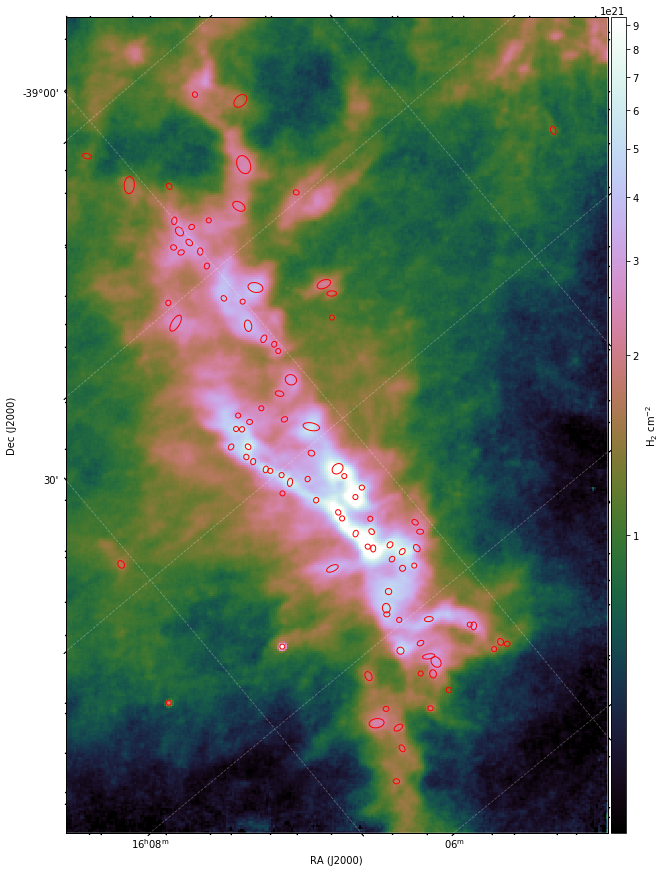

In [7]:
fig_all = plt.figure(1, figsize=(15,15))

fig = aplpy.FITSFigure(figfile,figure=fig_all)
fig.show_colorscale(cmap='cubehelix',stretch='arcsinh')
fig.add_colorbar()
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')
#fig.set_title("NGC2264")
fig.add_grid()
fig.grid.set_color('white')
fig.grid.set_alpha(0.3)
fig.grid.set_linestyle('--')
fig.show_ellipses(ac, dec, width/3600, height/3600, angle=angle-90., edgecolor='red', facecolor='none')
#for ii in range(256):
#    fig.add_label(ac[ii], dec[ii], ii, color='black',fontsize=18)
#ii = 32
#fig.add_label(ac[ii], dec[ii], ii, color='yellow',fontsize=18)
(xp, yp) = fig.world2pixel(ac, dec)

#plt.tight_layout()
#figpath = '/Users/robitaij/postdoc/NGC2264_letter/paper/figures/'
#plt.savefig(figpath+'NGC2264.pdf',dpi=150,bbox_inches='tight')

In [8]:
#Read map
HDU = fits.open(figfile)
im = HDU[0].data

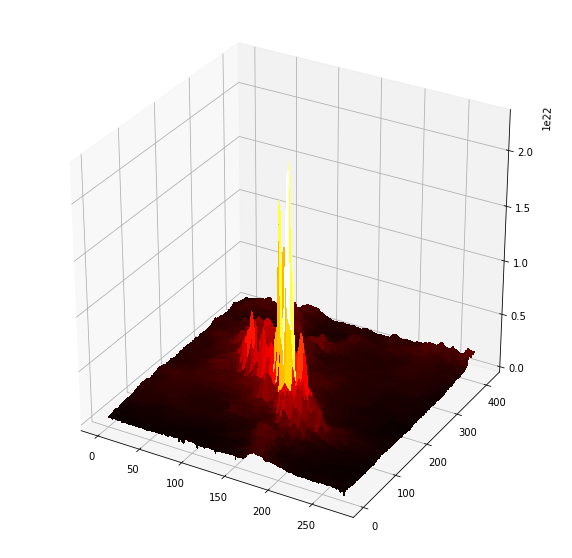

In [9]:
from mpl_toolkits.mplot3d import Axes3D
dim2=im.shape[0]
dim1=im.shape[1]
X=np.linspace(0,dim1-1,dim1)
Y=np.linspace(0,dim2-1,dim2)
X,Y=np.meshgrid(X,Y)
fig=plt.figure(figsize=(10,10))
ax=plt.axes(projection='3d')
#ax.set_zlim([-0.3,0.3])
ax.plot_surface(X,Y,im,cmap='hot',antialiased=False)
#ax.view_init(45,45)

In [10]:
#Read map
HDU = fits.open(figfile)
im = HDU[0].data
header = HDU[0].header

#Resolution in arcmin
reso = HDU[0].header['CDELT2'] * 60.

In [11]:
#Set a list of q
q=[]
q=[2.5]*26
newdim = np.array((550,400))

#Wavelet power spectrum
wt, S11a, wav_k, S1a, q = fan_trans(im, reso=reso, q=q, qdyn=True, skewl=0.4, arrdim = newdim, smooth=False, angular=True)

400 550


In [12]:
#Resolution in arcmin
reso = HDU[0].header['CDELT2'] * 60.

meanim = np.mean(im)
na = im.shape[1]
nb = im.shape[0]
imzm = im - meanim

#Apodization
tapper = apodize(nb,na,0.98)
imt = imzm *tapper
newdim = np.array((550,400))
imr = padding(imt,newdim[0],newdim[1])

#Fourier power spectrum
tab_k, spec_k = powspec(imr, reso=reso)

noise = spec_k[-1]

In [13]:
beam500 = fits.open('/user/workdir/albouyg/Gouldbelt/empiral_spire_beam_500.fits')[0].data

beam500r = padding(beam500,newdim[0],newdim[1])
Bwt, BS11a, wav_k, BS1a, Bq = fan_trans(beam500r, reso=reso, q=0, smooth=False, angular=False)
del Bwt, BS11a, Bq

BS1an = BS1a / BS1a[3]
BS1an[:3] = 1.0  #Spectrum normalisation

tab_k, spec_kbeam = powspec(beam500r, reso=reso)
spec_kbeamn = spec_kbeam/spec_kbeam[0]

Power law fit
Coherent wavelet
A, Gamma, P0 =  1.5885563428181136e+41 -2.2153176626767426 0.0
Gaussian wavelet
A, Gamma, P0 =  2.21346e+37 -4.88435 3.7496e+39


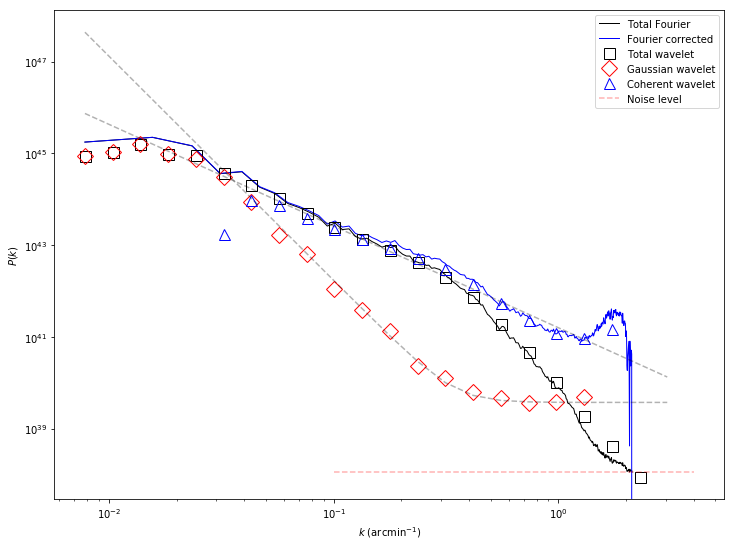

In [14]:
#Power spectra fits
A_gauss, gamma_gauss, P0_gauss = 0.000221346e+41, -4.88435, 0.0374960e+41
fit_gauss=A_gauss*wav_k**gamma_gauss+P0_gauss
A_cohe, cov = np.polyfit(np.log(wav_k[7:18]), np.log((S1a[1,7:18]-noise)/BS1an[7:18]),deg=1,cov=True)
fit_cohe=np.exp(A_cohe[1])*wav_k**A_cohe[0]

print('Power law fit')
print('Coherent wavelet')
print('A, Gamma, P0 = ', np.exp(A_cohe[1]), A_cohe[0], 0.0)
print('Gaussian wavelet')
print('A, Gamma, P0 = ', A_gauss, gamma_gauss, P0_gauss)

plt.figure(figsize(12,9))
plt.plot(tab_k, spec_k, color='black',label=r'Total Fourier', lw=1.0)
plt.plot(tab_k, (spec_k-noise)/spec_kbeamn, color='blue',label=r'Fourier corrected', lw=1.0)
plt.plot(wav_k[:-1], S1a[0,:-1],'s', markersize = 11, markerfacecolor='none', markeredgecolor='black', label='Total wavelet')
plt.plot(wav_k[:-1], (S1a[2,:-1]-noise)/BS1an[:-1],'D', markersize = 11, markerfacecolor='none', markeredgecolor='red', label='Gaussian wavelet')
plt.plot(wav_k[:-1], (S1a[1,:-1]-noise)/BS1an[:-1],'^', markersize = 11, markerfacecolor='none', markeredgecolor='blue', label='Coherent wavelet')
plt.plot([1e-1,4],[noise,noise],'--',color='red',linewidth=1.5,alpha=0.3,label='Noise level')
plt.plot(wav_k, fit_gauss,'--',color='black', linewidth=1.5, alpha=0.3)
plt.plot(wav_k, fit_cohe,'--',color='black', linewidth=1.5, alpha=0.3)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ (arcmin$^{-1}$)')
plt.ylabel(r'$P(k)$')
plt.legend()

## Image Reconstruction

In [15]:
M = wav_k.shape[0]

coherent = np.sum(wt[M:2*M,:,:,:],axis=(0,1)) + np.sum(wt[2*M:2*M+6,:,:,:],axis=(0,1)) + meanim
Gaussian = np.sum(wt[2*M:3*M,:,:,:],axis=(0,1)) + meanim

fits.writeto('/user/workdir/albouyg/Gouldbelt/Lupus_loc/lupus_coherent.fits',\
            coherent.real,header,overwrite=True)
fits.writeto('/user/workdir/albouyg/Gouldbelt/Lupus_loc/lupus_gauss.fits',\
            Gaussian.real,header,overwrite=True)

INFO: Auto-setting vmin to -1.124e+21 [aplpy.core]
INFO: Auto-setting vmax to  3.111e+21 [aplpy.core]
INFO: Auto-setting vmin to -9.128e+20 [aplpy.core]
INFO: Auto-setting vmax to  7.931e+21 [aplpy.core]


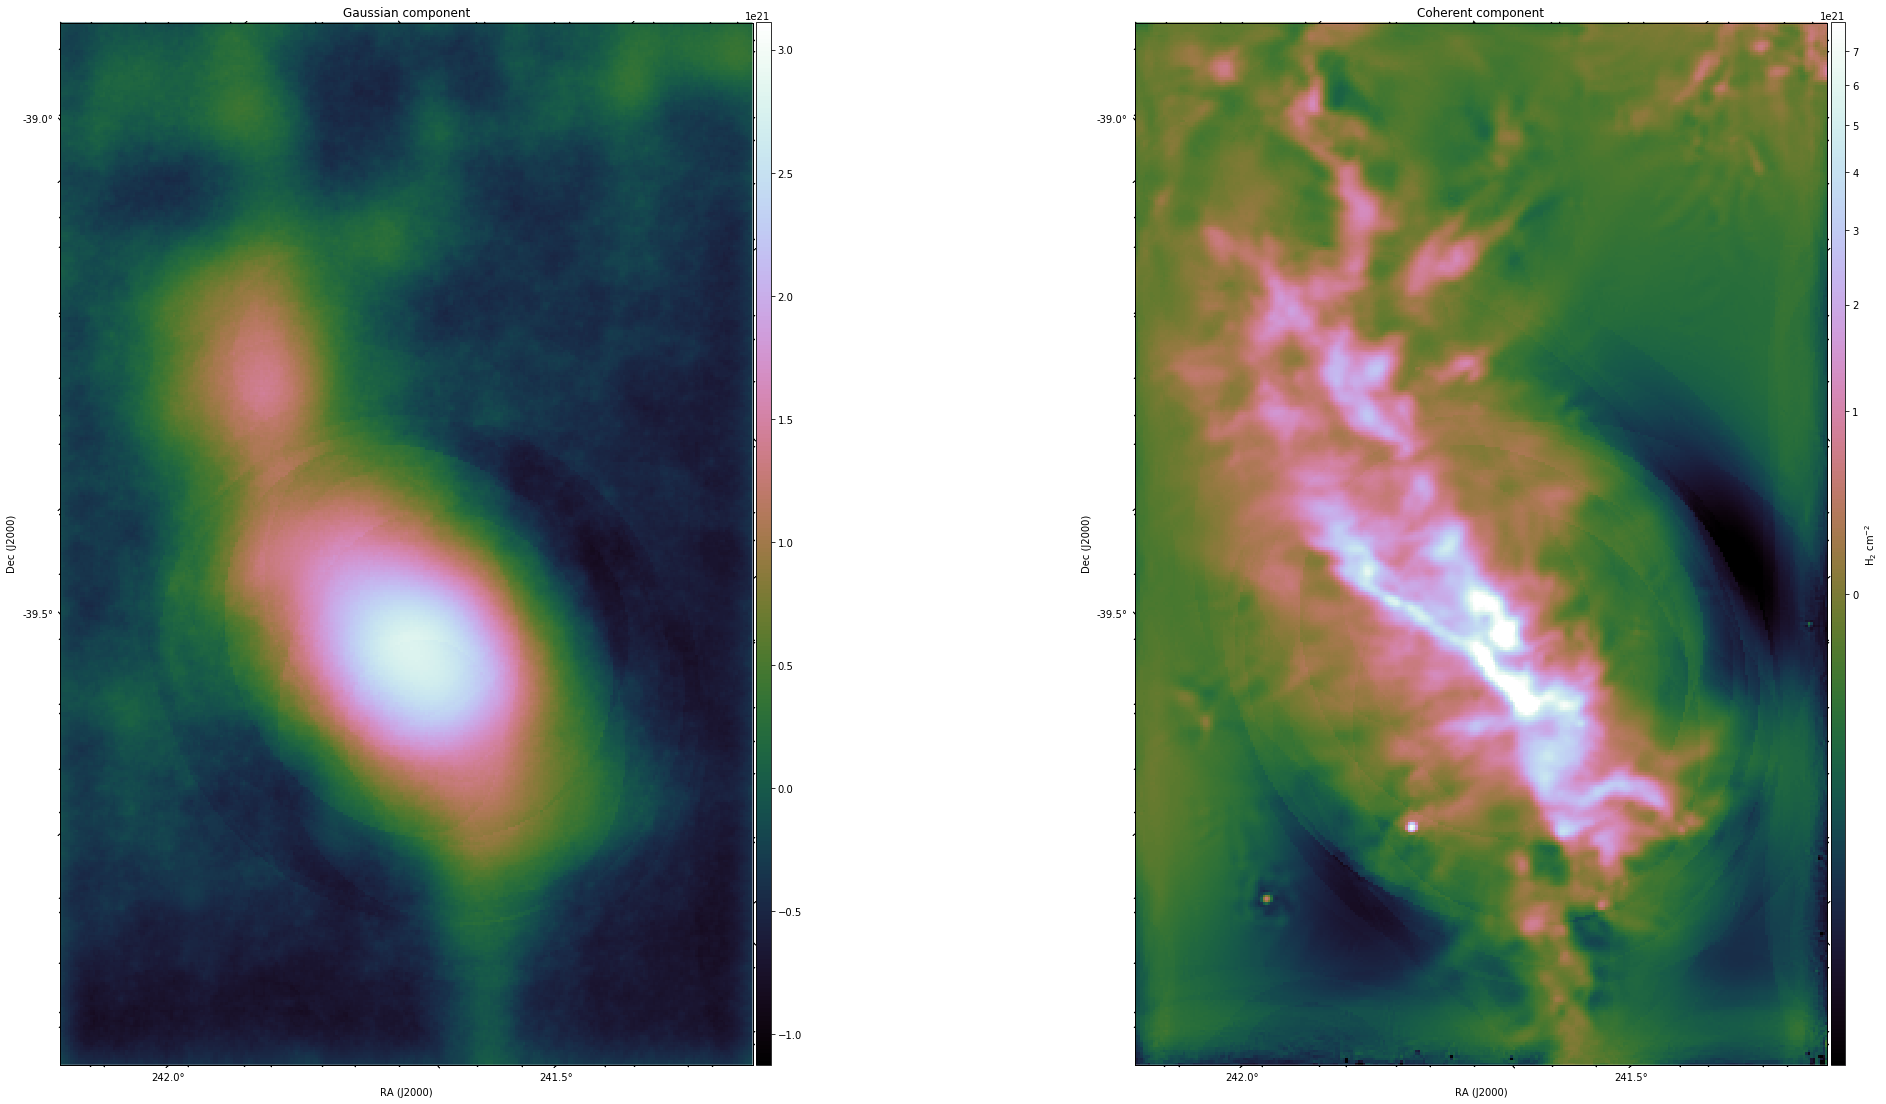

In [16]:
fig_all = plt.figure(1, figsize=(30,30))

figfile = '/user/workdir/albouyg/Gouldbelt/Lupus_loc/lupus_gauss.fits'
fig = aplpy.FITSFigure(figfile, figure=fig_all, convention='calabretta',subplot=(2, 2, 1))
fig.show_colorscale(cmap='cubehelix')
fig.tick_labels.set_xformat('dd.d')
fig.tick_labels.set_yformat('dd.d')
fig.add_colorbar()
fig.set_title('Gaussian component')

figfile = '/user/workdir/albouyg/Gouldbelt/Lupus_loc/lupus_coherent.fits'
fig = aplpy.FITSFigure(figfile, figure=fig_all, convention='calabretta',subplot=(2, 2, 2))
fig.show_colorscale(cmap='cubehelix',stretch='arcsinh')
fig.tick_labels.set_xformat('dd.d')
fig.tick_labels.set_yformat('dd.d')
fig.add_colorbar()
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')
fig.set_title('Coherent component')

plt.tight_layout()

Mass =  0.078
Power fit
A, Gamma =  1.874492682227172e+39 -4.654379733613745
Uncertainties =  10.90398021157206 2.0218022697531812


/nix/store/95553ya337nh3azs93fxgibhwfrsl81z-python3-3.7.2-env/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


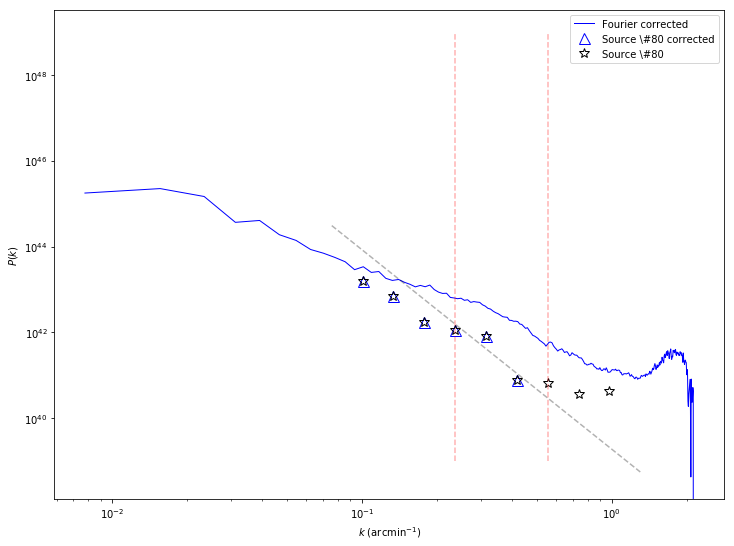

In [17]:
src = 80
xpr, ypr = np.int(xp[src]),np.int(yp[src])
coords = np.array((xpr, ypr))
smin, smax = (8,18)

locpow, xlcoords, ylcoords = locspec(coords, wav_k, wt[M:2*M,:,:], reso, smin, smax, radlim=0.5, phaslim=0.25)

#Clean NaN for fit
Mlocpow = np.nanmean(locpow, axis=0)
wav_nonan = wav_k[smin:smax+1]
wav_nonan = wav_nonan[~np.isnan(Mlocpow)]
Mlocpow_nonan = Mlocpow[~np.isnan(Mlocpow)]
BS1a_nonan = BS1an[smin:smax+1]
BS1a_nonan = BS1a_nonan[~np.isnan(Mlocpow)]

#Fit limits
flim = np.where((wav_nonan >= wav_k[smin+4]) & (wav_nonan < wav_k[smax-3]))

#Power spectra fits
A, cov = np.polyfit(np.log(wav_nonan[flim]), np.log((Mlocpow_nonan[flim]-noise)/(BS1a_nonan[flim])),deg=1,cov=True)
fit = np.exp(A[1])*wav_k[smin:smax+1]**A[0]
print('Mass = ', mass[src])
print('Power fit')
print('A, Gamma = ', np.exp(A[1]), A[0])
print('Uncertainties = ', np.exp(np.sqrt(np.diag(cov)[1])), np.sqrt(np.diag(cov)[0]))

plt.figure(figsize(12,9))
plt.plot(tab_k, (spec_k-noise)/spec_kbeamn, color='blue',label=r'Fourier corrected', lw=1.0)
plt.plot(wav_k[smin:smax-3], (Mlocpow[:-4]-noise)/(BS1an[smin:smax-3]),'^', markersize = 11, markerfacecolor='none', markeredgecolor='blue', label='Source \#'+np.str(src)+' corrected')
plt.plot(wav_nonan, (Mlocpow_nonan-noise)/BS1a_nonan,'*', markersize = 11, markerfacecolor='none', markeredgecolor='black', label='Source \#'+np.str(src))
plt.plot(wav_k[smin:smax+1], fit,'--',color='black', linewidth=1.5, alpha=0.3)
plt.plot([wav_k[smin+4],wav_k[smin+4]], [1e39,1e49],'--',color='red', linewidth=1.5, alpha=0.3)
plt.plot([wav_k[smax-3],wav_k[smax-3]], [1e39,1e49],'--',color='red', linewidth=1.5, alpha=0.3)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ (arcmin$^{-1}$)')
plt.ylabel(r'$P(k)$')
plt.legend()

### Loop over all sources

In [18]:
smin, smax = (8,18)
powlaw = np.zeros(100)
plevel = np.zeros(100)
powlaw_sig=np.zeros(100)
plevel_sig=np.zeros(100)
allxlcoords = np.zeros((100,11,smax - smin + 1))
allylcoords = np.zeros((100,11,smax - smin + 1))

for src in range(100):
    xpr, ypr = np.int(xp[src]),np.int(yp[src])
    coords = np.array((xpr, ypr))
    if (coords[0] > 0) & (coords[1] > 0) & (coords[1] < wt.shape[2]) & (coords[0] < wt.shape[3]):# & (src != 74) :
        locpow, xlcoords, ylcoords = locspec(coords, wav_k, wt[M:2*M,:,], reso, smin, smax, radlim=0.5, phaslim=0.25)
        allxlcoords[src,:,:] = xlcoords
        allylcoords[src,:,:] = ylcoords
    Mlocpow = np.nanmean(locpow, axis=0)
    #Clean NaN for fit
    Mlocpow = np.nanmean(locpow, axis=0)
    wav_nonan = wav_k[smin:smax+1]
    wav_nonan = wav_nonan[~np.isnan(Mlocpow)]
    Mlocpow_nonan = Mlocpow[~np.isnan(Mlocpow)]
    BS1a_nonan = BS1an[smin:smax+1]
    BS1a_nonan = BS1a_nonan[~np.isnan(Mlocpow)]
    #Fit limits
    flim = np.where((wav_nonan >= wav_k[smin+3]) & (wav_nonan < wav_k[smax-3]))
    #Power spectra fits
    if flim[0].size > 2:
        A, cov = np.polyfit(np.log(wav_nonan[flim]), np.log((Mlocpow_nonan[flim]-noise)/(BS1a_nonan[flim])),deg=1,cov=True)
        powlaw[src]= A[0]
        plevel[src]= np.exp(A[1])
        powlaw_sig[src]=np.sqrt(np.diag(cov)[0])
        plevel_sig[src]=np.exp(np.sqrt(np.diag(cov)[1]))
    else:
        powlaw[src]= 'nan'
        plevel[src]= 'nan'
        powlaw_sig[src]='nan'
        plevel_sig[src]='nan'

/nix/store/95553ya337nh3azs93fxgibhwfrsl81z-python3-3.7.2-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
/nix/store/95553ya337nh3azs93fxgibhwfrsl81z-python3-3.7.2-env/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice


Text(0, 0.5, 'Counts')

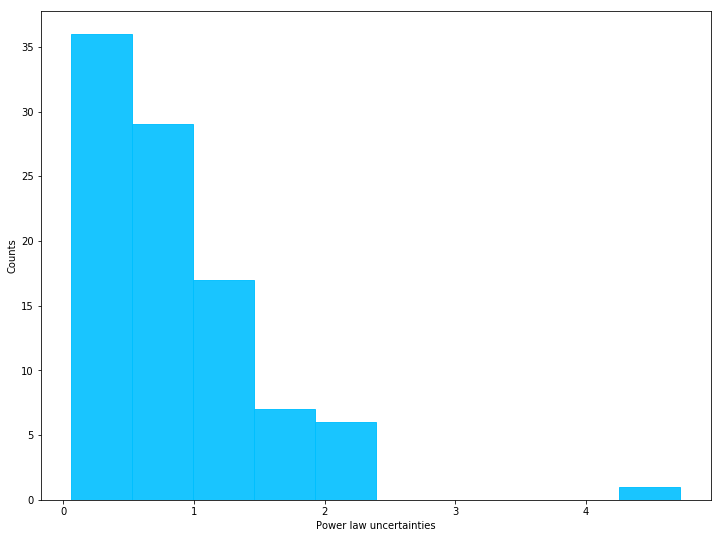

In [19]:
sighist, sigedges = np.histogram(powlaw_sig[~np.isnan(powlaw_sig)] , bins=10)

figure(figsize = (12,9))
plt.bar(sigedges[:-1], sighist, width=np.diff(sigedges), align="edge",\
        edgecolor='#00BFFF',facecolor='#00BFFF',alpha=0.9,\
        label= r'Power laws')
#plt.plot([-4.0,-4.0], [0,38],'--',color='red', linewidth=1.5, alpha=1.0)
#plt.plot([-2.5,-2.5], [0,38],'--',color='red', linewidth=1.5, alpha=1.0)
#plt.xlim([-4.0,-0.5])
plt.xlabel(r'Power law uncertainties')
plt.ylabel(r'Counts')

/nix/store/95553ya337nh3azs93fxgibhwfrsl81z-python3-3.7.2-env/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


Text(0, 0.5, 'Counts')

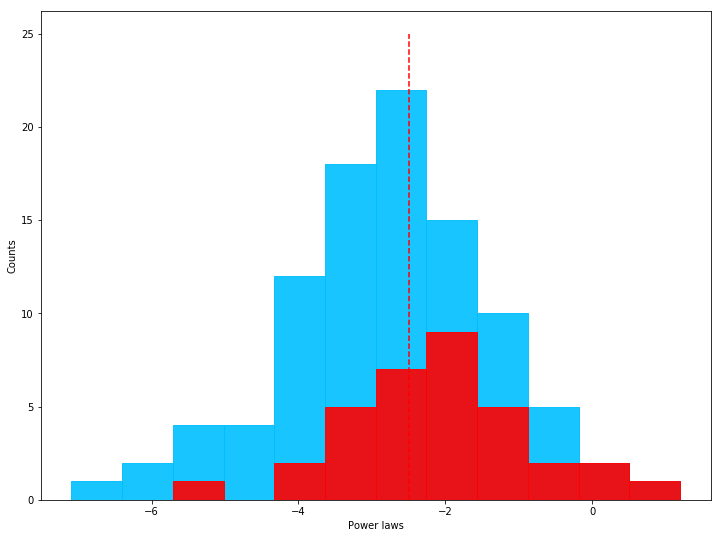

In [20]:
histo, edges = np.histogram(powlaw[~np.isnan(powlaw)],bins=12)
histo1, edges1 = np.histogram(powlaw[(~np.isnan(powlaw)) & (powlaw_sig < .5)],bins=edges)

figure(figsize = (12,9))
plt.bar(edges[:-1], histo, width=np.diff(edges), align="edge",\
        edgecolor='#00BFFF',facecolor='#00BFFF',alpha=0.9,\
        label= r'Power laws')
plt.bar(edges1[:-1], histo1, width=np.diff(edges1), align="edge",\
        edgecolor='red',facecolor='red',alpha=0.9,\
        label= r'Power laws')
#plt.plot([-4.0,-4.0], [0,38],'--',color='red', linewidth=1.5, alpha=1.0)
plt.plot([-2.5,-2.5], [0,25],'--',color='red', linewidth=1.5, alpha=1.0)
#plt.xlim([-4.0,-0.5])
plt.xlabel(r'Power laws')
plt.ylabel(r'Counts')

#figpath = '/Users/robitaij/postdoc/NGC2264_letter/paper/figures/'
#plt.savefig(figpath+'NGC2264_locpow_dist.pdf',dpi=150,bbox_inches='tight')

/nix/store/95553ya337nh3azs93fxgibhwfrsl81z-python3-3.7.2-env/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'Counts')

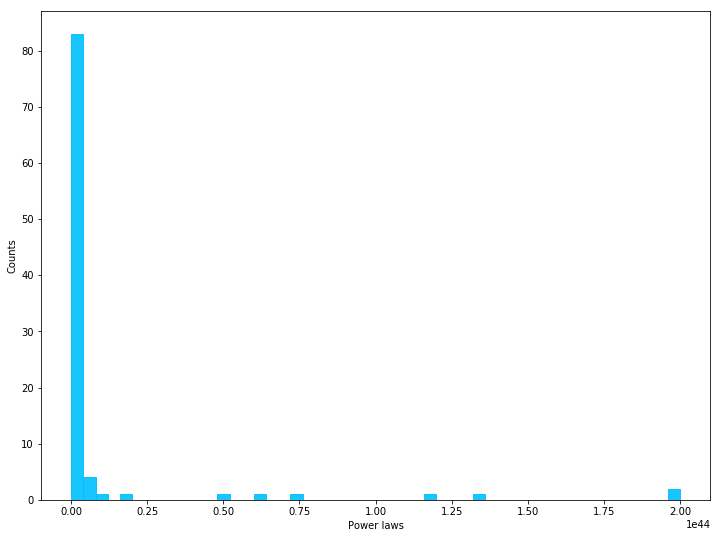

In [21]:
Plhisto, Pledges = np.histogram(plevel[(~np.isnan(plevel)) & (plevel < 1e45)],bins=50)

figure(figsize = (12,9))
plt.bar(Pledges[:-1], Plhisto, width=np.diff(Pledges), align="edge",\
        edgecolor='#00BFFF',facecolor='#00BFFF',alpha=0.9,\
        label= r'Power laws')
#plt.plot([-4.0,-4.0], [0,38],'--',color='red', linewidth=1.5, alpha=1.0)
#plt.plot([-2.5,-2.5], [0,38],'--',color='red', linewidth=1.5, alpha=1.0)
#plt.xlim([-4.0,-0.5])
plt.xlabel(r'Power laws')
plt.ylabel(r'Counts')

#figpath = '/Users/robitaij/postdoc/talks/ALMA-IMF/images/'
#plt.savefig(figpath+'NGC2264_Plevel_dist.pdf',dpi=150,bbox_inches='tight')

/nix/store/95553ya337nh3azs93fxgibhwfrsl81z-python3-3.7.2-env/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.
/nix/store/95553ya337nh3azs93fxgibhwfrsl81z-python3-3.7.2-env/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


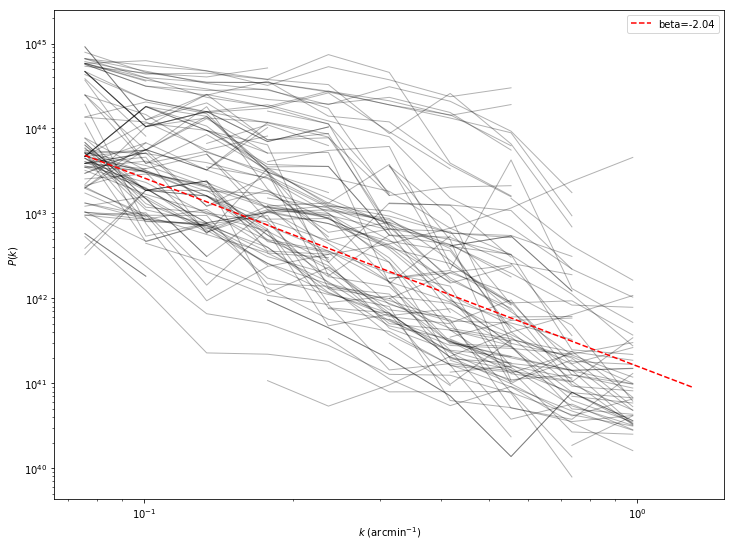

In [22]:
condition=np.where(powlaw_sig < .75)
plt.figure(figsize(12,9))
#for src in condition[0]:
for src in range(100):
    xpr, ypr = np.int(xp[src]),np.int(yp[src])
    coords = np.array((xpr, ypr))
    if (coords[0] > 0) & (coords[1] > 0) & (coords[1] < wt.shape[2]) & (coords[0] < wt.shape[3]):
        locpow, xlcoords, ylcoords = locspec(coords, wav_k, wt, reso, smin, smax, radlim=0.5, phaslim=0.25)
    Mlocpow = np.nanmean(locpow, axis=0)
    plt.plot(wav_k[smin:smax+1], (Mlocpow-noise)/BS1an[smin:smax+1],lw=1.0, alpha=0.3, color='black')

plt.plot(wav_k[smin:smax+1], fit_cohe[smin:smax+1],'--',color='red',lw=1.5, ls='--', label='beta=-2.04')
#plt.plot(wav_k[smin:smax+1], mod1[smin:smax+1],lw=1.5, ls='-.', color='black', label='beta=-4.0')
#plt.plot(wav_k[smin:smax+1], mod2[smin:smax+1],lw=1.5, ls='--', color='black', label='beta=-2.5')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ (arcmin$^{-1}$)')
plt.ylabel(r'$P(k)$')
plt.legend()

#plt.savefig(figpath+'NGC2264_locpow_all.pdf',dpi=150,bbox_inches='tight')

/nix/store/95553ya337nh3azs93fxgibhwfrsl81z-python3-3.7.2-env/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys


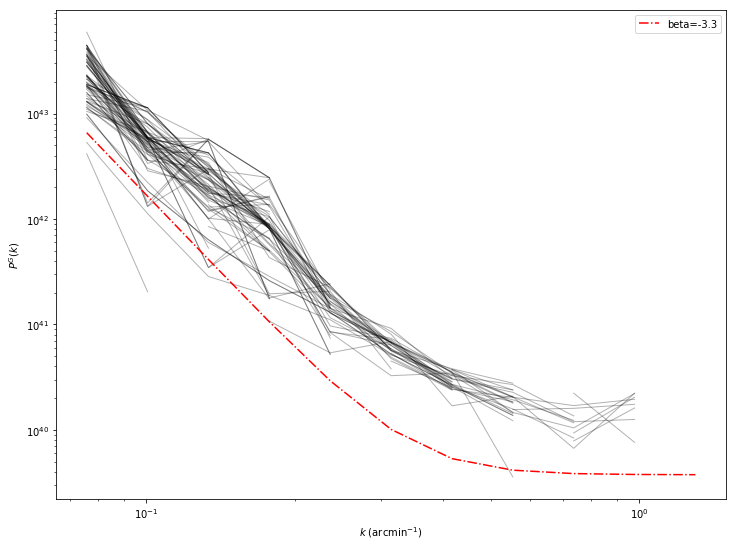

In [23]:
plt.figure(figsize(12,9))
for src in range(100):
    xpr, ypr = np.int(xp[src]),np.int(yp[src])
    coords = np.array((xpr, ypr))
    if (coords[0] > 0) & (coords[1] > 0) & (coords[1] < wt.shape[2]) & (coords[0] < wt.shape[3]):
        locpow, xlcoords, ylcoords = locspec(coords, wav_k, wt[2*M:3*M,:,:], reso, smin, smax, radlim=0.5, phaslim=0.25)
    Mlocpow = np.nanmean(locpow, axis=0)
    plt.plot(wav_k[smin:smax+1], (Mlocpow-noise)/BS1an[smin:smax+1],lw=1.0, alpha=0.3, color='black')

plt.plot(wav_k[smin:smax+1], fit_gauss[smin:smax+1],lw=1.5, ls='-.', color='red', label='beta=-3.3')
#plt.plot(wav_k[smin:smax+1], mod2[smin:smax+1],lw=1.5, ls='--', color='black', label='beta=-2.5')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ (arcmin$^{-1}$)')
plt.ylabel(r'$P^{G}(k)$')
plt.legend()

#plt.savefig(figpath+'NGC2264_locpow_Gaussian_all.pdf',dpi=150,bbox_inches='tight')

/nix/store/95553ya337nh3azs93fxgibhwfrsl81z-python3-3.7.2-env/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys


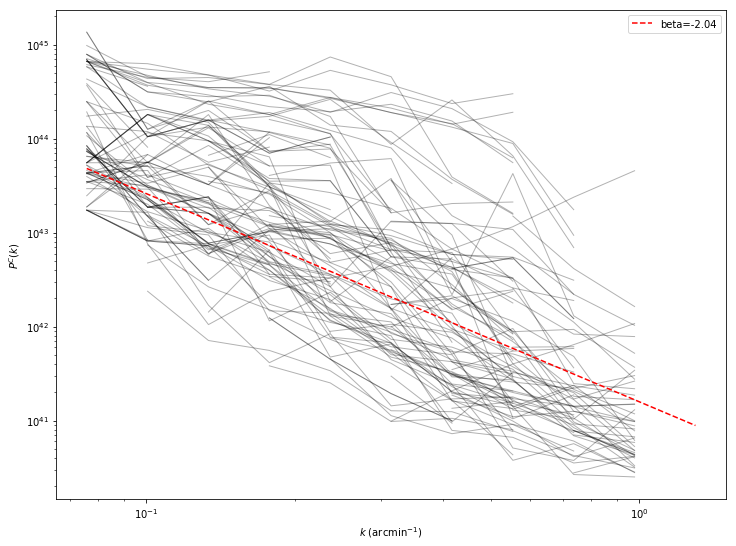

In [24]:
plt.figure(figsize(12,9))
for src in range(100):
    xpr, ypr = np.int(xp[src]),np.int(yp[src])
    coords = np.array((xpr, ypr))
    if (coords[0] > 0) & (coords[1] > 0) & (coords[1] < wt.shape[2]) & (coords[0] < wt.shape[3]):
        locpow, xlcoords, ylcoords = locspec(coords, wav_k, wt[M:2*M], reso, smin, smax, radlim=0.5, phaslim=0.25)
    Mlocpow = np.nanmean(locpow, axis=0)
    plt.plot(wav_k[smin:smax+1], (Mlocpow-noise)/BS1an[smin:smax+1],lw=1.0, alpha=0.3, color='black')

plt.plot(wav_k[smin:smax+1], fit_cohe[smin:smax+1],'--',color='red',lw=1.5, ls='--', label='beta=-2.04')
#plt.plot(wav_k[smin:smax+1], mod1[smin:smax+1],lw=1.5, ls='-.', color='black', label='beta=-4.0')
#plt.plot(wav_k[smin:smax+1], mod2[smin:smax+1],lw=1.5, ls='--', color='black', label='beta=-2.5')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ (arcmin$^{-1}$)')
plt.ylabel(r'$P^{C}(k)$')
plt.legend()

#plt.savefig(figpath+'NGC2264_locpow_all.pdf',dpi=150,bbox_inches='tight')

/nix/store/95553ya337nh3azs93fxgibhwfrsl81z-python3-3.7.2-env/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


Text(0.5, 0, 'Power Law')

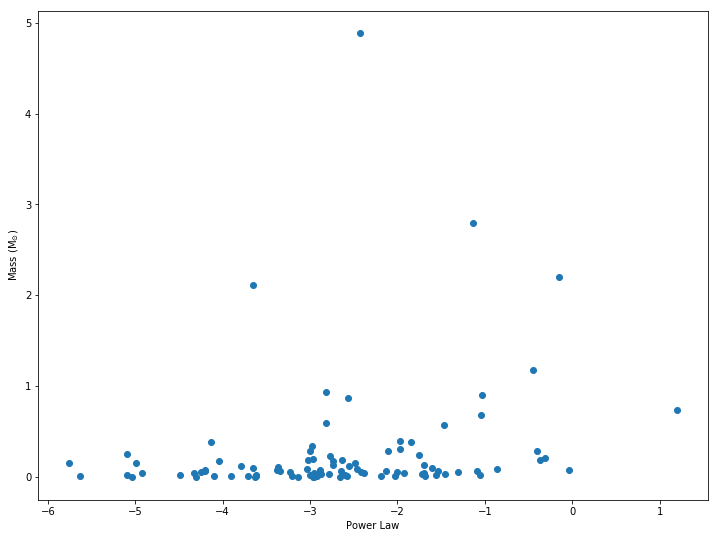

In [25]:
figure(figsize=(12,9))
scatter(powlaw[powlaw > -6.0],mass[powlaw > -6.0])
#scatter(powlaw[plevel > np.exp(1.84*powlaw + 106.15)],mass[plevel > np.exp(1.84*powlaw + 106.15)])
#scatter(powlaw,mass)
#xscale('log')
#yscale('log')
ylabel(r'Mass (M$_{\odot}$)')
xlabel(r'Power Law')

#plt.tight_layout()
#figpath = '/Users/robitaij/postdoc/NGC2264_letter/paper/figures/'
#plt.savefig(figpath+'NGC2264_powlaw_mass.pdf',dpi=150,bbox_inches='tight')

/nix/store/95553ya337nh3azs93fxgibhwfrsl81z-python3-3.7.2-env/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


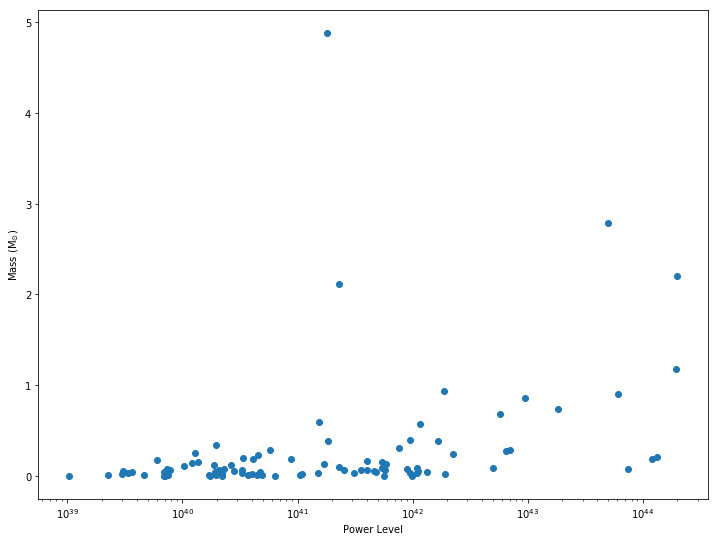

In [26]:
mlim = 5.

figure(figsize=(12,9))
scatter(plevel[powlaw > -6.0],mass[powlaw > -6.0])
ylabel(r'Mass (M$_{\odot}$)')
xlabel(r'Power Level')
xscale('log')
#yscale('log')

#plt.tight_layout()
#figpath = '/Users/robitaij/postdoc/NGC2264_letter/paper/figures/'
#plt.savefig(figpath+'NGC2264_plevel_mass.pdf',dpi=150,bbox_inches='tight')

/nix/store/95553ya337nh3azs93fxgibhwfrsl81z-python3-3.7.2-env/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice
/nix/store/95553ya337nh3azs93fxgibhwfrsl81z-python3-3.7.2-env/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice


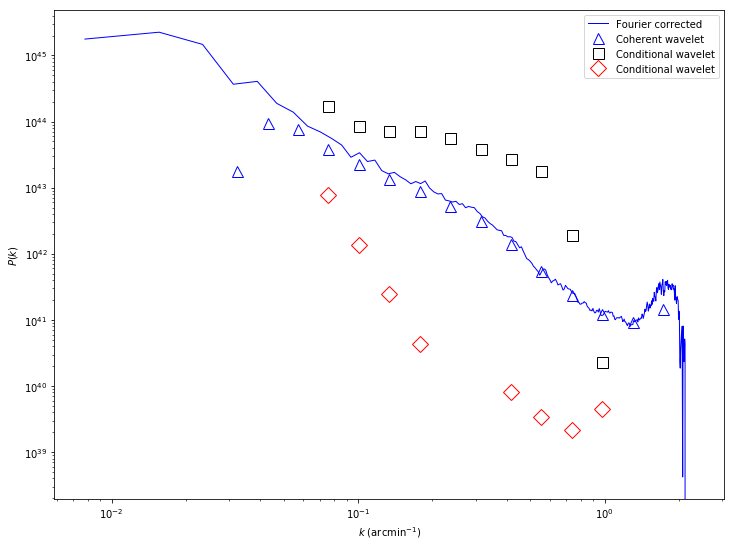

In [27]:
smin2, smax2 = (8,18)

condition = np.where((mass > 1.0))
#condition = np.where((powlaw >= -3.0) & (mass > 5.0))
#condition = np.where((plevel > 2.5e+43))
#condition = np.where((powlaw > -2.5) & (mass > 1.0))
#condition = np.where((powlaw > -3.0) & (powlaw <= -2.0) & (mass < 5.0))
#condition = np.where((powlaw < -1.5) & (mass > 20.0))
#condition = np.where(plevel < np.exp(1.84*powlaw + 106.15))
cond_powC = np.zeros((condition[0].size,smax2 - smin2 + 1))
cond_powG = np.zeros((condition[0].size,smax2 - smin2 + 1))

ii = 0
#for src in range(100):
for src in condition[0]:
#src = 45
    xpr, ypr = np.int(xp[src]),np.int(yp[src])
    coords = np.array((xpr, ypr))
    if (coords[0] > 0) & (coords[1] > 0) & (coords[1] < wt.shape[2]) & (coords[0] < wt.shape[3]):
        locpow, xlcoords, ylcoords = locspec(coords, wav_k, wt[M:2*M,:,:], reso, smin2, smax2, radlim=0.5, phaslim=0.25)
    Mlocpow = np.nanmean(locpow, axis=0)
    cond_powC[ii,:] = Mlocpow
    ii =+ 1
    
ii = 0
#for src in range(100):
for src in condition[0]:
#src = 45
    xpr, ypr = np.int(xp[src]),np.int(yp[src])
    coords = np.array((xpr, ypr))
    if (coords[0] > 0) & (coords[1] > 0) & (coords[1] < wt.shape[2]) & (coords[0] < wt.shape[3]):
        locpow, xlcoords, ylcoords = locspec(coords, wav_k, wt[2*M:3*M,:,:], reso, smin2, smax2, radlim=0.5, phaslim=0.25)
    Mlocpow = np.nanmean(locpow, axis=0)
    cond_powG[ii,:] = Mlocpow
    ii =+ 1
    
Mcond_powC = np.nanmean(cond_powC, axis=0)
Mcond_powG = np.nanmean(cond_powG, axis=0)

plt.figure(figsize(12,9))
plt.plot(tab_k, (spec_k-noise)/spec_kbeamn, color='blue',label=r'Fourier corrected', lw=1.0)
plt.plot(wav_k[:-1], (S1a[1,:-1]-noise)/BS1an[:-1],'^', markersize = 11, markerfacecolor='none', markeredgecolor='blue', label='Coherent wavelet')
plt.plot(wav_k[smin2:smax2+1], (Mcond_powC-noise)/BS1an[smin2:smax2+1],'s', markersize = 11, markerfacecolor='none', markeredgecolor='black', label='Conditional wavelet')
plt.plot(wav_k[smin2:smax2+1], (Mcond_powG-noise)/BS1an[smin2:smax2+1],'D', markersize = 11, markerfacecolor='none', markeredgecolor='red', label='Conditional wavelet')
#plt.plot(wav_k, fit,'--',color='black', linewidth=1.5, alpha=0.3)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ (arcmin$^{-1}$)')
plt.ylabel(r'$P(k)$')
plt.legend()

/nix/store/95553ya337nh3azs93fxgibhwfrsl81z-python3-3.7.2-env/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/nix/store/95553ya337nh3azs93fxgibhwfrsl81z-python3-3.7.2-env/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice


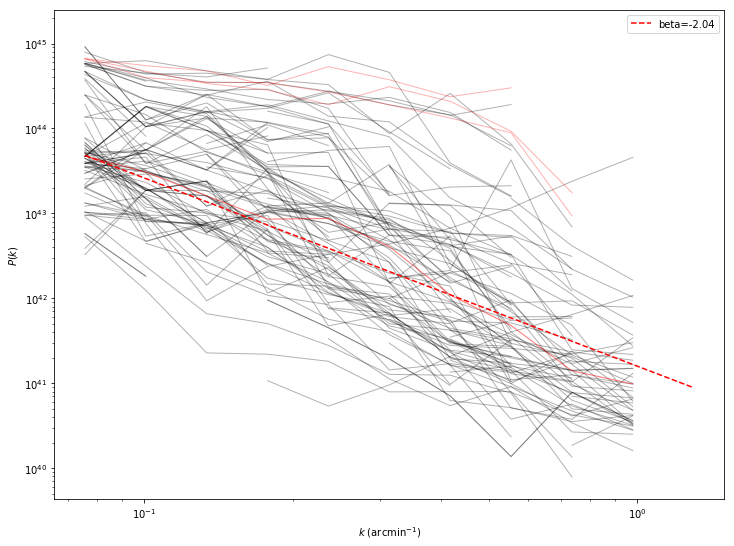

In [28]:
plt.figure(figsize(12,9))
condition = np.where(mass <= 1.)
for src in condition[0]:
    xpr, ypr = np.int(xp[src]),np.int(yp[src])
    coords = np.array((xpr, ypr))
    if (coords[0] > 0) & (coords[1] > 0) & (coords[1] < wt.shape[2]) & (coords[0] < wt.shape[3]):
        locpow, xlcoords, ylcoords = locspec(coords, wav_k, wt, reso, smin, smax, radlim=0.5, phaslim=0.25)
    Mlocpow = np.nanmean(locpow, axis=0)
    plt.plot(wav_k[smin:smax+1], (Mlocpow-noise)/BS1an[smin:smax+1],lw=1.0, alpha=0.3, color='black')
    
condition = np.where(mass > 1.)
for src in condition[0]:
    xpr, ypr = np.int(xp[src]),np.int(yp[src])
    coords = np.array((xpr, ypr))
    if (coords[0] > 0) & (coords[1] > 0) & (coords[1] < wt.shape[2]) & (coords[0] < wt.shape[3]):
        locpow, xlcoords, ylcoords = locspec(coords, wav_k, wt, reso, smin, smax, radlim=0.5, phaslim=0.25)
    Mlocpow = np.nanmean(locpow, axis=0)
    plt.plot(wav_k[smin:smax+1], (Mlocpow-noise)/BS1an[smin:smax+1],lw=1.0, alpha=0.3, color='red')

plt.plot(wav_k[smin:smax+1], fit_cohe[smin:smax+1],'--',color='red',lw=1.5, ls='--', label='beta=-2.04')
#plt.plot(wav_k[smin:smax+1], mod1[smin:smax+1],lw=1.5, ls='-.', color='black', label='beta=-4.0')
#plt.plot(wav_k[smin:smax+1], mod2[smin:smax+1],lw=1.5, ls='--', color='black', label='beta=-2.5')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ (arcmin$^{-1}$)')
plt.ylabel(r'$P(k)$')
plt.legend()

#plt.savefig(figpath+'NGC2264_locpow_all.pdf',dpi=150,bbox_inches='tight')

/nix/store/95553ya337nh3azs93fxgibhwfrsl81z-python3-3.7.2-env/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/nix/store/95553ya337nh3azs93fxgibhwfrsl81z-python3-3.7.2-env/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice


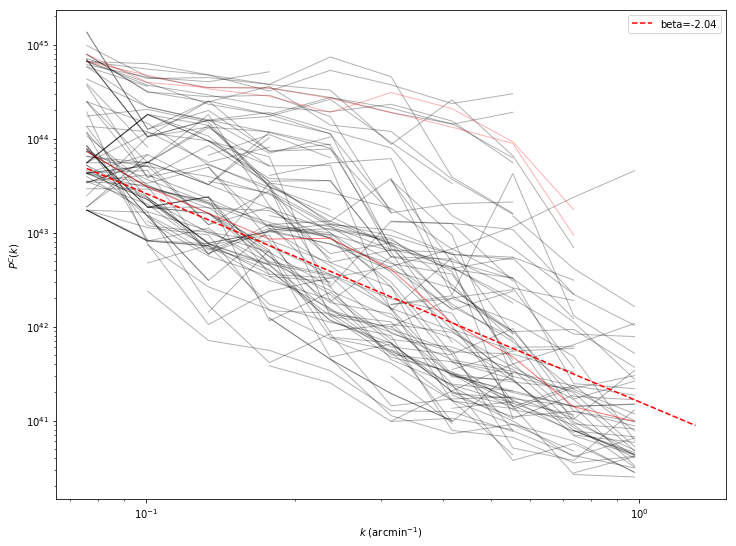

In [29]:
plt.figure(figsize(12,9))
condition = np.where(mass <= 2.)
for src in condition[0]:
    xpr, ypr = np.int(xp[src]),np.int(yp[src])
    coords = np.array((xpr, ypr))
    if (coords[0] > 0) & (coords[1] > 0) & (coords[1] < wt.shape[2]) & (coords[0] < wt.shape[3]):
        locpow, xlcoords, ylcoords = locspec(coords, wav_k, wt[M:2*M], reso, smin, smax, radlim=0.5, phaslim=0.25)
    Mlocpow = np.nanmean(locpow, axis=0)
    plt.plot(wav_k[smin:smax+1], (Mlocpow-noise)/BS1an[smin:smax+1], lw=1.0, alpha=0.3, color='black')
    
#condition = np.where(plevel > np.exp((1.92*powlaw + 105.94)))
condition = np.where(mass > 2.)
for src in condition[0]:
    xpr, ypr = np.int(xp[src]),np.int(yp[src])
    coords = np.array((xpr, ypr))
    if (coords[0] > 0) & (coords[1] > 0) & (coords[1] < wt.shape[2]) & (coords[0] < wt.shape[3]):
        locpow, xlcoords, ylcoords = locspec(coords, wav_k, wt[M:2*M], reso, smin, smax, radlim=0.5, phaslim=0.25)
    Mlocpow = np.nanmean(locpow, axis=0)
    plt.plot(wav_k[smin:smax+1], (Mlocpow-noise)/BS1an[smin:smax+1],lw=1.0, alpha=0.3, color='red')

plt.plot(wav_k[smin:smax+1], fit_cohe[smin:smax+1],'--',color='red',lw=1.5, ls='--', label='beta=-2.04')
#plt.plot(wav_k[smin:smax+1], fit_gauss[smin:smax+1],'--',color='blue',lw=1.5, ls='--', label='beta=-3.3')
#plt.plot(wav_k[smin:smax+1], mod1[smin:smax+1],lw=1.5, ls='-.', color='black', label='beta=-4.0')
#plt.plot(wav_k[smin:smax+1], mod2[smin:smax+1],lw=1.5, ls='--', color='black', label='beta=-2.5')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ (arcmin$^{-1}$)')
plt.ylabel(r'$P^{C}(k)$')
plt.legend()

/nix/store/95553ya337nh3azs93fxgibhwfrsl81z-python3-3.7.2-env/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


INFO: Auto-setting vmin to -9.074e+20 [aplpy.core]
INFO: Auto-setting vmax to  7.539e+21 [aplpy.core]


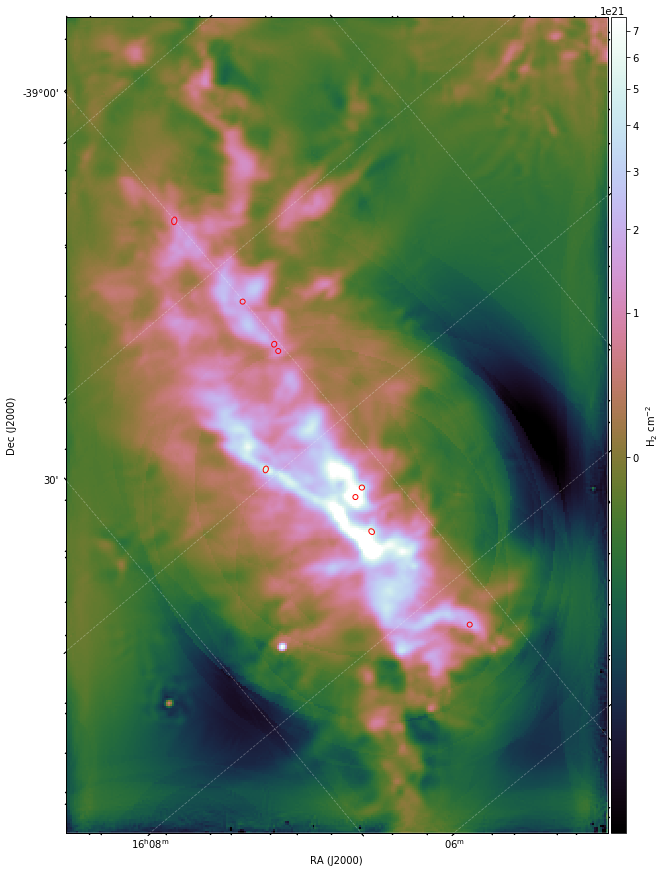

In [30]:
condition = np.where((powlaw > -1.5) & (mass < 0.5))

fig_all = plt.figure(1, figsize=(15,15))
fig = aplpy.FITSFigure(figfile,figure=fig_all)
fig.show_colorscale(cmap='cubehelix',stretch='arcsinh')
fig.add_colorbar()
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')
#fig.set_title("NGC2264")
fig.add_grid()
fig.grid.set_color('white')
fig.grid.set_alpha(0.3)
fig.grid.set_linestyle('--')
fig.show_ellipses(ac[condition[0]], dec[condition[0]], width[condition[0]]/3600, height[condition[0]]/3600, angle=angle[condition[0]]-90., edgecolor='red', facecolor='none')
#for ii in range(256):
#    fig.add_label(ac[ii], dec[ii], ii, color='black',fontsize=18)
#ii = 32
#fig.add_label(ac[ii], dec[ii], ii, color='yellow',fontsize=18)
(xp, yp) = fig.world2pixel(ac, dec)

#plt.tight_layout()
#figpath = '/Users/robitaij/postdoc/NGC2264_letter/paper/figures/'
#plt.savefig(figpath+'NGC2264.pdf',dpi=150,bbox_inches='tight')